In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader
from BESTRq_classes.conformer import ConformerEncoder
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram

## Defining classes and training functions

In [3]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [3]:
def pretrain(trainloader, validloader, model, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(model.encoder.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for inputs, _ in trainloader:
            optimizer.zero_grad()
            inputs = inputs.view(1, -1, 600).to(device)
            encoder_outs, labels = model(inputs, masking = True)
            loss = loss_function(encoder_outs, labels.view(-1))
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(encoder_outs, dim=1)
            total += labels.size(1)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs = inputs.view(1, -1, 600).to(device)
                encoder_outs, labels = model(inputs, masking = False)
                loss = loss_function(encoder_outs, labels.view(-1))
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(encoder_outs, dim=1)
                total += labels.size(1)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [2]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(600, torch.Size([175995, 600]))

In [5]:
class GRUPredictor(nn.Module):
    """GRUPredictor is a recurrent model. It takes as input a vector and predict
    the next one given past observations."""
    def __init__(self, input_dim=600, hidden_dim=50, nstack = 3, dropout=0):
        super(GRUPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout
        self.gru = nn.GRU(input_size=input_dim, hidden_size = hidden_dim,  num_layers = nstack)
        self.linear = nn.Linear(in_features = hidden_dim, out_features = 200)
        self.drop = nn.Dropout(p = dropout)
    def init_hidden(self, bsz):
        # This function is given: understand it.
        self.h = th.zeros(self.nstack, bsz, self.hidden_dim)

    def forward(self, inputs, h0=None):
        if h0 == None:
          h0 = self.init_hidden(inputs.shape[0])
        hidden, h0 = self.gru(inputs, h0)
        out = self.drop(hidden)
        out = self.linear(hidden)
        return out

In [6]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim=600, hidden_dim=100, nstack=2, dropout=0, codebook_size = 50, embedding_dim = 50):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout
        # LSTM layer
        self.lstm = nn.LSTM(input_size= input_dim, hidden_size=hidden_dim, num_layers=nstack, bidirectional= True)

        # Linear layers for attention
        self.attention_linear = nn.Linear(2*hidden_dim, 1)
        self.context_linear = nn.Linear(2*hidden_dim, hidden_dim)

        # Final linear layer
        self.linear = nn.Linear(hidden_dim, codebook_size)

        # Dropout layer
        self.drop = nn.Dropout(p=dropout)


    def init_hidden(self, bsz):
        # Initialize hidden state for LSTM
        return (th.zeros(2*self.nstack, bsz, self.hidden_dim),
            th.zeros(2*self.nstack, bsz, self.hidden_dim))


    def forward(self, inputs, h0=None):
        if h0 is None:
            (h0, c0) = self.init_hidden(inputs.size(1))  # Use size(1) to get the batch size

        h0, c0 = h0.to(device), c0.to(device)

        # LSTM forward pass
        lstm_output, _ = self.lstm(inputs, (h0, c0))


        # Compute attention weights
        attention_weights = F.softmax(self.attention_linear(lstm_output), dim=0)

        # Apply attention to LSTM output
        attention_applied = th.sum(attention_weights * lstm_output, dim=0)

        # Compute context vector
        context = self.context_linear(attention_applied)

        context = F.relu(context)

        # Apply dropout
        out = self.drop(context)

        #Linear layer
        out = self.linear(out)


        #Softmax layer
        out = F.softmax(out, dim= 1)

        return out


In [7]:
def train_decoder(trainloader, validloader, encoder, decoder, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(encoder.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        encoder.eval()
        decoder.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels = inputs.view(1, -1, 600).to(device), labels.to(device)
            with th.no_grad():
                encoder_outs = encoder(inputs)
            decoder_outs = decoder(encoder_outs.view(1, -1, 70))
            loss = loss_function(decoder_outs.view(-1, 6), labels.view(-1))
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(decoder_outs, dim=2)
            total += labels.size(0)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        decoder.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs, labels = inputs.view(1, -1, 600).to(device), labels.to(device)
                encoder_outs = model(inputs)
                decoder_outs = decoder(encoder_outs.view(1, -1, 70))
                loss = loss_function(decoder_outs.view(-1, 6), labels.view(-1))
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(encoder_outs, dim=2)
                total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

## First overview on raw signals

In [9]:
device = 'cpu'
tmp = RandomProjectionQuantizer(input_dim= 600, quantizer_dim= 100, codebook_size= 200,random_state= 2673834267383, device = device)
input_size = (175995, 600)
mask_time_indices = th.ones(input_size[0], input_size[1], dtype=th.bool, device= device).to(device)
mask_time_indices = mask_time_indices.view(-1, input_size[1]).unsqueeze(0)
xtrain_batched = xtrain.unsqueeze(0).to(device)
results  = tmp(xtrain_batched)
results.unique()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

Text(0.5, 1.0, 'Visualisation du masque')

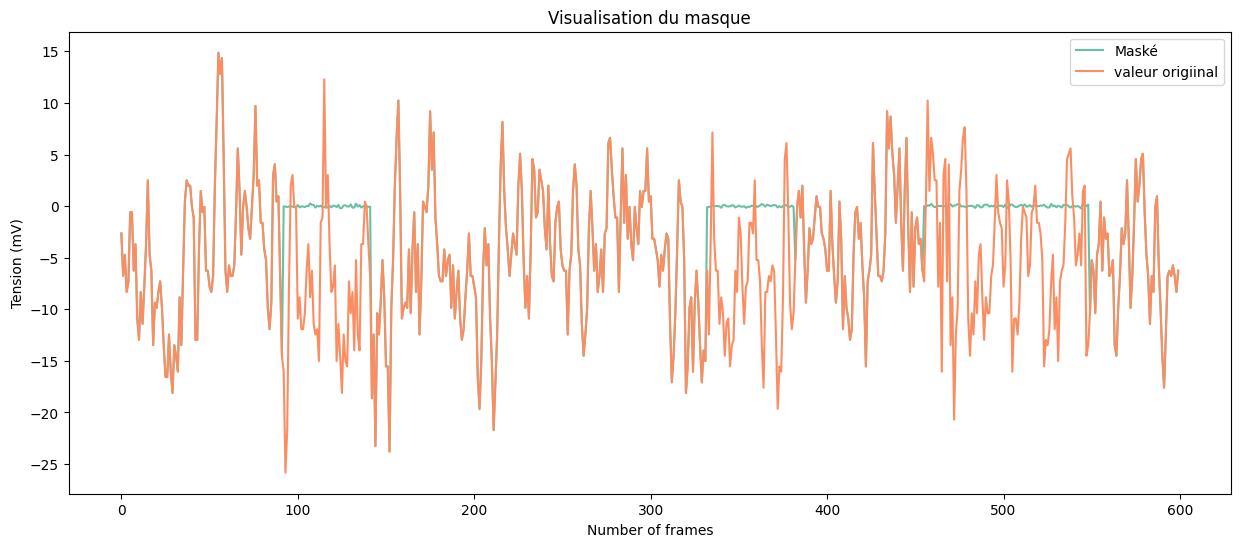

In [335]:
#Viz of the mask
model = BestRqFramework(encoder= AttentionLSTM(dropout = 0.1, hidden_dim = 150, nstack= 2),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=50,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=1,
                        batch_size=200)

inputs = xtrain[:200].to(device).view(-1, 200, 600)

masked_values,_ = model.masking(inputs)


plt.figure(figsize=(15,6))
for i in range(1):
    plt.plot(masked_values[0,i,:].cpu().detach().numpy(), label = 'Maské')
    plt.plot(inputs[0, i ,:].cpu().detach().numpy(), label ='valeur origiinal')
plt.legend()
plt.xlabel('Number of frames')
plt.ylabel('Tension (mV)')
plt.title('Visualisation du masque')

In [5]:
conformer_model = ConformerEncoder(input_size = 600, num_blocks = 3, kernel_size = 3, num_heads = 4).to(device)

In [275]:
device = th.device('mps')

encoder = AttentionLSTM(dropout= 0.2, hidden_dim = 100, codebook_size= 70, nstack = 2)

model = BestRqFramework(encoder= encoder,
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=200,
                        num_code_books= 70,
                        mask_time= 50,
                        stride_time=1,
                        random_state=6618181,
                        mask_prob=0.01,
                        batch_size=400,
                        device = device)


inputs = xtrain[:200].to(device).view(-1, 200, 600)
    # `(batch size)` Number of available time steps per batch
input_lengths = th.tensor([200, 871, 389, 487]).to(device)

input_values, idx = model(inputs, masking = False)

input_values, idx

(tensor([[0.0141, 0.0155, 0.0140,  ..., 0.0130, 0.0144, 0.0148],
         [0.0143, 0.0154, 0.0142,  ..., 0.0129, 0.0144, 0.0147],
         [0.0145, 0.0157, 0.0139,  ..., 0.0127, 0.0145, 0.0149],
         ...,
         [0.0146, 0.0157, 0.0138,  ..., 0.0125, 0.0142, 0.0153],
         [0.0149, 0.0159, 0.0141,  ..., 0.0129, 0.0145, 0.0150],
         [0.0145, 0.0156, 0.0140,  ..., 0.0128, 0.0143, 0.0149]],
        device='mps:0', grad_fn=<SoftmaxBackward0>),
 tensor([[10, 16, 25, 12, 62, 55,  6, 68, 50, 55, 10, 54, 55, 10, 25,  4, 14,  1,
          37, 28, 10, 54, 29, 37, 59, 35, 16, 15, 60,  9, 12,  9, 14,  1, 65,  6,
          42, 10, 15, 19, 35,  7,  1,  1,  2, 11, 25, 32, 16, 25, 55, 42, 36, 25,
          60,  1, 54,  1, 10, 17,  2, 13, 38, 14,  6, 39, 19, 50,  9, 23, 11, 16,
          10,  1,  6,  6, 31,  3, 10, 37,  1, 37, 60, 54, 50, 15, 29, 10, 25, 26,
          65, 19,  4, 29, 25, 10, 21, 11, 19,  1, 34, 16, 19, 17, 55,  3, 12,  6,
           9, 25, 35,  3,  1, 23, 19, 50, 55, 53, 

Tried doing with hidden_dim = 200, mask_prob = 0.3, epochs = 100 but signs of overfitting appeared for about 30 epochs

In [276]:
dataset_t = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(dataset_t, batch_size= 500, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
valid_loader = DataLoader(dataset_v, batch_size= 500, shuffle=True)
train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain(trainloader= train_loader, validloader= valid_loader, model = model, epochs= 100, device = device, lr = 1e-3)

  1%|          | 1/100 [00:32<52:57, 32.09s/it]

Epoch 1/100, Train Loss: 4.073843022639101, Validation Loss: 4.014802400882427, Training Accuracy: 0.20500582402909173, Validation Accuracy: 0.2576986245124204


  2%|▏         | 2/100 [01:03<51:26, 31.49s/it]

Epoch 2/100, Train Loss: 3.9920918027108367, Validation Loss: 3.9813101964119153, Training Accuracy: 0.2813034461206284, Validation Accuracy: 0.2927017039622254


  3%|▎         | 3/100 [01:33<49:59, 30.92s/it]

Epoch 3/100, Train Loss: 3.9466329284689645, Validation Loss: 3.9434698483882804, Training Accuracy: 0.327486576323191, Validation Accuracy: 0.3295011291315951


  4%|▍         | 4/100 [02:00<47:02, 29.40s/it]

Epoch 4/100, Train Loss: 3.913149368356575, Validation Loss: 3.9241350369575696, Training Accuracy: 0.36077729480951165, Validation Accuracy: 0.34972284951755284


  5%|▌         | 5/100 [02:28<45:35, 28.80s/it]

Epoch 5/100, Train Loss: 3.8920706036415966, Validation Loss: 3.912795800429124, Training Accuracy: 0.3817892553765732, Validation Accuracy: 0.36157873126668033


  6%|▌         | 6/100 [02:55<44:26, 28.37s/it]

Epoch 6/100, Train Loss: 3.877773792906241, Validation Loss: 3.9009919472229786, Training Accuracy: 0.39593738458478933, Validation Accuracy: 0.37245945391090124


  7%|▋         | 7/100 [03:25<44:42, 28.84s/it]

Epoch 7/100, Train Loss: 3.8671142052520406, Validation Loss: 3.8990056881537805, Training Accuracy: 0.4064604108071252, Validation Accuracy: 0.37348593717922396


  8%|▊         | 8/100 [03:55<44:37, 29.11s/it]

Epoch 8/100, Train Loss: 3.8586006117137996, Validation Loss: 3.895957573866233, Training Accuracy: 0.4150288360464786, Validation Accuracy: 0.37738657359885036


  9%|▉         | 9/100 [04:22<43:20, 28.58s/it]

Epoch 9/100, Train Loss: 3.852407892319289, Validation Loss: 3.8928882892315206, Training Accuracy: 0.42118810193471407, Validation Accuracy: 0.38020940258673785


 10%|█         | 10/100 [04:51<42:47, 28.53s/it]

Epoch 10/100, Train Loss: 3.8451825481924145, Validation Loss: 3.888623152023707, Training Accuracy: 0.4284439898860763, Validation Accuracy: 0.38431533566002873


 11%|█         | 11/100 [05:19<42:18, 28.53s/it]

Epoch 11/100, Train Loss: 3.8395310389724644, Validation Loss: 3.8843985948807154, Training Accuracy: 0.43384187050768486, Validation Accuracy: 0.3894990761650585


 12%|█▏        | 12/100 [05:50<42:55, 29.27s/it]

Epoch 12/100, Train Loss: 3.835160827772184, Validation Loss: 3.881340986643082, Training Accuracy: 0.43875110088354785, Validation Accuracy: 0.39155204270170396


 13%|█▎        | 13/100 [06:17<41:35, 28.68s/it]

Epoch 13/100, Train Loss: 3.8276724205775694, Validation Loss: 3.873883063976581, Training Accuracy: 0.4460865365493338, Validation Accuracy: 0.3996099363580374


 14%|█▍        | 14/100 [06:44<40:05, 27.97s/it]

Epoch 14/100, Train Loss: 3.8208297911015423, Validation Loss: 3.8713149413084373, Training Accuracy: 0.4531321912554334, Validation Accuracy: 0.40222746869226034


 15%|█▌        | 15/100 [07:13<40:17, 28.44s/it]

Epoch 15/100, Train Loss: 3.81404056196863, Validation Loss: 3.8703512106186304, Training Accuracy: 0.4599164748998551, Validation Accuracy: 0.40309997947033466


 16%|█▌        | 16/100 [07:44<40:50, 29.18s/it]

Epoch 16/100, Train Loss: 3.8089448606426064, Validation Loss: 3.8653855996254163, Training Accuracy: 0.4647007017244808, Validation Accuracy: 0.40838636830219666


 17%|█▋        | 17/100 [08:15<41:15, 29.82s/it]

Epoch 17/100, Train Loss: 3.8032629069956867, Validation Loss: 3.8610928669953957, Training Accuracy: 0.47045654706099604, Validation Accuracy: 0.41218435639499074


 18%|█▊        | 18/100 [08:53<43:45, 32.02s/it]

Epoch 18/100, Train Loss: 3.797459889541973, Validation Loss: 3.858219006122687, Training Accuracy: 0.4763373959487485, Validation Accuracy: 0.41454526791213303


 19%|█▉        | 19/100 [09:21<41:57, 31.08s/it]

Epoch 19/100, Train Loss: 3.791662970049815, Validation Loss: 3.855028439790775, Training Accuracy: 0.4823659763061451, Validation Accuracy: 0.41772736604393346


 20%|██        | 20/100 [09:50<40:31, 30.39s/it]

Epoch 20/100, Train Loss: 3.786489611999555, Validation Loss: 3.8525284009102063, Training Accuracy: 0.48724679678399957, Validation Accuracy: 0.42096078833915007


 21%|██        | 21/100 [10:18<38:50, 29.50s/it]

Epoch 21/100, Train Loss: 3.781227866357023, Validation Loss: 3.850183817056509, Training Accuracy: 0.4925764936503878, Validation Accuracy: 0.42332169985629237


 22%|██▏       | 22/100 [10:45<37:35, 28.91s/it]

Epoch 22/100, Train Loss: 3.775500949810852, Validation Loss: 3.845978150000939, Training Accuracy: 0.4981959714764624, Validation Accuracy: 0.4273763087661671


 23%|██▎       | 23/100 [11:12<36:22, 28.34s/it]

Epoch 23/100, Train Loss: 3.7705134390430017, Validation Loss: 3.8446225203000584, Training Accuracy: 0.5030313361175034, Validation Accuracy: 0.4277869020734962


 24%|██▍       | 24/100 [11:39<35:25, 27.96s/it]

Epoch 24/100, Train Loss: 3.765186294913292, Validation Loss: 3.8412950222308817, Training Accuracy: 0.5086280860251712, Validation Accuracy: 0.43297064257852597


 25%|██▌       | 25/100 [12:06<34:34, 27.66s/it]

Epoch 25/100, Train Loss: 3.7604840966788204, Validation Loss: 3.8371114241771207, Training Accuracy: 0.5132475354413477, Validation Accuracy: 0.4362040648737426


 26%|██▌       | 26/100 [12:33<33:49, 27.43s/it]

Epoch 26/100, Train Loss: 3.755633745681156, Validation Loss: 3.834866701028286, Training Accuracy: 0.5180090343475667, Validation Accuracy: 0.4381030589201396


 27%|██▋       | 27/100 [13:01<33:22, 27.43s/it]

Epoch 27/100, Train Loss: 3.752084345980124, Validation Loss: 3.8315485440767727, Training Accuracy: 0.5215829995170317, Validation Accuracy: 0.44128515705194005


 28%|██▊       | 28/100 [13:28<32:53, 27.41s/it]

Epoch 28/100, Train Loss: 3.747308599677953, Validation Loss: 3.83015915675041, Training Accuracy: 0.5262365408108185, Validation Accuracy: 0.44297885444467255


 29%|██▉       | 29/100 [13:55<32:22, 27.36s/it]

Epoch 29/100, Train Loss: 3.742577974769202, Validation Loss: 3.8293834832998424, Training Accuracy: 0.5311457711866815, Validation Accuracy: 0.44380004105933074


 30%|███       | 30/100 [14:22<31:52, 27.32s/it]

Epoch 30/100, Train Loss: 3.73862196166407, Validation Loss: 3.8256900065984483, Training Accuracy: 0.5353049802551209, Validation Accuracy: 0.44718743584479576


 31%|███       | 31/100 [14:51<31:52, 27.71s/it]

Epoch 31/100, Train Loss: 3.7344076484441757, Validation Loss: 3.82383786714994, Training Accuracy: 0.5393107758743146, Validation Accuracy: 0.4497536440156025


 32%|███▏      | 32/100 [15:20<31:50, 28.09s/it]

Epoch 32/100, Train Loss: 3.729854880408807, Validation Loss: 3.8196815771934314, Training Accuracy: 0.5438279496576607, Validation Accuracy: 0.45385957708889346


 33%|███▎      | 33/100 [15:48<31:21, 28.09s/it]

Epoch 33/100, Train Loss: 3.7267333777113394, Validation Loss: 3.820050863119272, Training Accuracy: 0.5470723600102275, Validation Accuracy: 0.45370560459864506


 34%|███▍      | 34/100 [16:16<30:46, 27.98s/it]

Epoch 34/100, Train Loss: 3.722901479764418, Validation Loss: 3.8214155527261586, Training Accuracy: 0.550788374669735, Validation Accuracy: 0.4519092588790803


 35%|███▌      | 35/100 [16:43<30:05, 27.78s/it]

Epoch 35/100, Train Loss: 3.720237102698196, Validation Loss: 3.817907535112821, Training Accuracy: 0.5534304951845223, Validation Accuracy: 0.4554506261547937


 36%|███▌      | 36/100 [17:13<30:09, 28.27s/it]

Epoch 36/100, Train Loss: 3.7171481908722357, Validation Loss: 3.8158581317999425, Training Accuracy: 0.5564703542714282, Validation Accuracy: 0.4570416752206939


 37%|███▋      | 37/100 [17:42<30:06, 28.67s/it]

Epoch 37/100, Train Loss: 3.7142983749508858, Validation Loss: 3.816349188486735, Training Accuracy: 0.559657944827978, Validation Accuracy: 0.45699035105727775


 38%|███▊      | 38/100 [18:14<30:26, 29.46s/it]

Epoch 38/100, Train Loss: 3.7111328447406944, Validation Loss: 3.814010944121923, Training Accuracy: 0.5626296201596637, Validation Accuracy: 0.46001847669882984


 39%|███▉      | 39/100 [18:48<31:37, 31.11s/it]

Epoch 39/100, Train Loss: 3.708234130658887, Validation Loss: 3.815673284041576, Training Accuracy: 0.5656467513281628, Validation Accuracy: 0.4575549168548553


 40%|████      | 40/100 [19:21<31:32, 31.54s/it]

Epoch 40/100, Train Loss: 3.706430845639922, Validation Loss: 3.8138117606823263, Training Accuracy: 0.5670956561265945, Validation Accuracy: 0.45950523506466845


 41%|████      | 41/100 [19:50<30:17, 30.81s/it]

Epoch 41/100, Train Loss: 3.7042425071651284, Validation Loss: 3.810639827679365, Training Accuracy: 0.5692548083752379, Validation Accuracy: 0.46289262985013346


 42%|████▏     | 42/100 [20:21<29:53, 30.92s/it]

Epoch 42/100, Train Loss: 3.7016074698079717, Validation Loss: 3.8087546703142996, Training Accuracy: 0.5720787522372794, Validation Accuracy: 0.4644323547526175


 43%|████▎     | 43/100 [20:50<28:48, 30.33s/it]

Epoch 43/100, Train Loss: 3.699827520007437, Validation Loss: 3.8105563628367887, Training Accuracy: 0.5739708514446433, Validation Accuracy: 0.4620714432354753


 44%|████▍     | 44/100 [21:19<27:48, 29.79s/it]

Epoch 44/100, Train Loss: 3.6968838064508005, Validation Loss: 3.8096913129855423, Training Accuracy: 0.5768459331231001, Validation Accuracy: 0.463097926503798


 45%|████▌     | 45/100 [21:48<27:05, 29.56s/it]

Epoch 45/100, Train Loss: 3.6952132738449355, Validation Loss: 3.8069094511178823, Training Accuracy: 0.5784141594931674, Validation Accuracy: 0.4659207554916855


 46%|████▌     | 46/100 [22:16<26:17, 29.22s/it]

Epoch 46/100, Train Loss: 3.692832454361699, Validation Loss: 3.807591970150287, Training Accuracy: 0.5807721810278701, Validation Accuracy: 0.4656128105111887


 47%|████▋     | 47/100 [22:46<25:50, 29.26s/it]

Epoch 47/100, Train Loss: 3.6910335340283136, Validation Loss: 3.808338055243859, Training Accuracy: 0.5825392766839967, Validation Accuracy: 0.46489427222336277


 48%|████▊     | 48/100 [23:14<25:09, 29.03s/it]

Epoch 48/100, Train Loss: 3.6888643780892547, Validation Loss: 3.805108321018708, Training Accuracy: 0.5846757010142334, Validation Accuracy: 0.4684869636624923


 49%|████▉     | 49/100 [23:43<24:40, 29.04s/it]

Epoch 49/100, Train Loss: 3.6862435313788326, Validation Loss: 3.8070940176645913, Training Accuracy: 0.5871700900593767, Validation Accuracy: 0.4659720796551016


 50%|█████     | 50/100 [24:11<23:49, 28.59s/it]

Epoch 50/100, Train Loss: 3.68479052524675, Validation Loss: 3.803268695488954, Training Accuracy: 0.5887780902866558, Validation Accuracy: 0.4701293368918087


 51%|█████     | 51/100 [24:39<23:22, 28.63s/it]

Epoch 51/100, Train Loss: 3.6834704449230973, Validation Loss: 3.8031063752296643, Training Accuracy: 0.5902610869626979, Validation Accuracy: 0.4702833093820571


 52%|█████▏    | 52/100 [25:10<23:24, 29.26s/it]

Epoch 52/100, Train Loss: 3.6812378019094467, Validation Loss: 3.8011269936194787, Training Accuracy: 0.592442967129748, Validation Accuracy: 0.4722849517552864


 53%|█████▎    | 53/100 [25:43<23:42, 30.27s/it]

Epoch 53/100, Train Loss: 3.678425194864923, Validation Loss: 3.802339798364884, Training Accuracy: 0.5953010028693997, Validation Accuracy: 0.47105317183329914


 54%|█████▍    | 54/100 [26:11<22:42, 29.61s/it]

Epoch 54/100, Train Loss: 3.6758861893957313, Validation Loss: 3.7977320903386826, Training Accuracy: 0.597721526179721, Validation Accuracy: 0.47536440156025456


 55%|█████▌    | 55/100 [26:39<21:49, 29.10s/it]

Epoch 55/100, Train Loss: 3.674570396542549, Validation Loss: 3.79572440416385, Training Accuracy: 0.5990511094065172, Validation Accuracy: 0.4784951755286389


 56%|█████▌    | 56/100 [27:07<21:07, 28.81s/it]

Epoch 56/100, Train Loss: 3.6722738681869074, Validation Loss: 3.797890375822018, Training Accuracy: 0.6013011733287877, Validation Accuracy: 0.47474851159926096


 57%|█████▋    | 57/100 [27:35<20:35, 28.73s/it]

Epoch 57/100, Train Loss: 3.670530498705127, Validation Loss: 3.799233479377551, Training Accuracy: 0.6032330463933634, Validation Accuracy: 0.47351673167727365


 58%|█████▊    | 58/100 [28:05<20:11, 28.85s/it]

Epoch 58/100, Train Loss: 3.6691346249797125, Validation Loss: 3.80252113709083, Training Accuracy: 0.6042955765788801, Validation Accuracy: 0.4704886060357216


 59%|█████▉    | 59/100 [28:38<20:33, 30.09s/it]

Epoch 59/100, Train Loss: 3.667805560610511, Validation Loss: 3.797086367240319, Training Accuracy: 0.6057558453365153, Validation Accuracy: 0.47675015397249026


 60%|██████    | 60/100 [29:07<20:00, 30.00s/it]

Epoch 60/100, Train Loss: 3.6654348610477014, Validation Loss: 3.79873173053448, Training Accuracy: 0.6082275064632517, Validation Accuracy: 0.4742865941285157


 61%|██████    | 61/100 [29:35<19:03, 29.31s/it]

Epoch 61/100, Train Loss: 3.6634815924546937, Validation Loss: 3.7946332540267553, Training Accuracy: 0.6101934714054377, Validation Accuracy: 0.47844385136522277


 62%|██████▏   | 62/100 [30:03<18:15, 28.82s/it]

Epoch 62/100, Train Loss: 3.662669296969067, Validation Loss: 3.7972911993662515, Training Accuracy: 0.6108866729168442, Validation Accuracy: 0.47618558817491274


 63%|██████▎   | 63/100 [30:31<17:40, 28.67s/it]

Epoch 63/100, Train Loss: 3.6603507697582245, Validation Loss: 3.7952131369175057, Training Accuracy: 0.6131196909003097, Validation Accuracy: 0.47834120303839045


 64%|██████▍   | 64/100 [30:59<17:05, 28.49s/it]

Epoch 64/100, Train Loss: 3.6583817452192307, Validation Loss: 3.79274267416734, Training Accuracy: 0.615318617006165, Validation Accuracy: 0.480804762882365


 65%|██████▌   | 65/100 [31:27<16:33, 28.40s/it]

Epoch 65/100, Train Loss: 3.6569027582352813, Validation Loss: 3.7928872352991347, Training Accuracy: 0.6165175147021222, Validation Accuracy: 0.47957298296037776


 66%|██████▌   | 66/100 [31:56<16:09, 28.52s/it]

Epoch 66/100, Train Loss: 3.6547945202751593, Validation Loss: 3.7910688045697336, Training Accuracy: 0.6188584902980199, Validation Accuracy: 0.4824471361116814


 67%|██████▋   | 67/100 [32:24<15:40, 28.49s/it]

Epoch 67/100, Train Loss: 3.6530326015569945, Validation Loss: 3.7917071733719263, Training Accuracy: 0.6205858120969345, Validation Accuracy: 0.48239581194826525


 68%|██████▊   | 68/100 [32:52<15:00, 28.14s/it]

Epoch 68/100, Train Loss: 3.65112399851734, Validation Loss: 3.791494528452555, Training Accuracy: 0.6225688229779255, Validation Accuracy: 0.4821391911311846


 69%|██████▉   | 69/100 [33:20<14:30, 28.08s/it]

Epoch 69/100, Train Loss: 3.6513536315072668, Validation Loss: 3.7931946974534254, Training Accuracy: 0.6221256285689934, Validation Accuracy: 0.4806507903921166


 70%|███████   | 70/100 [33:47<13:55, 27.85s/it]

Epoch 70/100, Train Loss: 3.6488311412659558, Validation Loss: 3.7882770697275796, Training Accuracy: 0.6246768374101537, Validation Accuracy: 0.48455142681174296


 71%|███████   | 71/100 [34:15<13:28, 27.89s/it]

Epoch 71/100, Train Loss: 3.6483585638078777, Validation Loss: 3.789019676355215, Training Accuracy: 0.6251200318190858, Validation Accuracy: 0.48352494354342024


 72%|███████▏  | 72/100 [34:42<12:55, 27.71s/it]

Epoch 72/100, Train Loss: 3.6468812471086327, Validation Loss: 3.7874994767017856, Training Accuracy: 0.6268075797607887, Validation Accuracy: 0.4854239375898173


 73%|███████▎  | 73/100 [35:10<12:25, 27.61s/it]

Epoch 73/100, Train Loss: 3.6463494531132956, Validation Loss: 3.789590542133038, Training Accuracy: 0.6271428165572885, Validation Accuracy: 0.48352494354342024


 74%|███████▍  | 74/100 [35:41<12:23, 28.58s/it]

Epoch 74/100, Train Loss: 3.643908479674296, Validation Loss: 3.7897426837529893, Training Accuracy: 0.6295462939288048, Validation Accuracy: 0.4840381851775816


 75%|███████▌  | 75/100 [36:14<12:28, 29.95s/it]

Epoch 75/100, Train Loss: 3.642222533171827, Validation Loss: 3.788603140757634, Training Accuracy: 0.6312849796869229, Validation Accuracy: 0.485321289262985


 76%|███████▌  | 76/100 [36:46<12:14, 30.59s/it]

Epoch 76/100, Train Loss: 3.6412701620297, Validation Loss: 3.789135291026189, Training Accuracy: 0.6321884144435922, Validation Accuracy: 0.48408950934099776


 77%|███████▋  | 77/100 [37:15<11:30, 30.04s/it]

Epoch 77/100, Train Loss: 3.6393582847985355, Validation Loss: 3.787696294295482, Training Accuracy: 0.6341146055285661, Validation Accuracy: 0.48537261342640114


 78%|███████▊  | 78/100 [37:45<11:01, 30.05s/it]

Epoch 78/100, Train Loss: 3.6389755179936234, Validation Loss: 3.7877100920065856, Training Accuracy: 0.6346146197335152, Validation Accuracy: 0.4854752617532334


 79%|███████▉  | 79/100 [38:14<10:25, 29.80s/it]

Epoch 79/100, Train Loss: 3.6370878233151003, Validation Loss: 3.7870549911107774, Training Accuracy: 0.6364612631040655, Validation Accuracy: 0.48650174502155613


 80%|████████  | 80/100 [38:45<10:06, 30.32s/it]

Epoch 80/100, Train Loss: 3.6368640668012877, Validation Loss: 3.788877939566588, Training Accuracy: 0.6365919486349044, Validation Accuracy: 0.4842948059946623


 81%|████████  | 81/100 [39:14<09:29, 29.95s/it]

Epoch 81/100, Train Loss: 3.6347511315887626, Validation Loss: 3.788250751984425, Training Accuracy: 0.6389215602715986, Validation Accuracy: 0.48470539930199136


 82%|████████▏ | 82/100 [39:43<08:52, 29.58s/it]

Epoch 82/100, Train Loss: 3.633230254731395, Validation Loss: 3.7865022879380446, Training Accuracy: 0.6402454615187931, Validation Accuracy: 0.48619380004105933


 83%|████████▎ | 83/100 [40:18<08:49, 31.16s/it]

Epoch 83/100, Train Loss: 3.632238332520832, Validation Loss: 3.7870114155304737, Training Accuracy: 0.6410523026222336, Validation Accuracy: 0.48568055840689794


 84%|████████▍ | 84/100 [40:53<08:36, 32.26s/it]

Epoch 84/100, Train Loss: 3.6308928165923464, Validation Loss: 3.789650837580363, Training Accuracy: 0.6425296173186739, Validation Accuracy: 0.4833196468897557


 85%|████████▌ | 85/100 [41:28<08:18, 33.21s/it]

Epoch 85/100, Train Loss: 3.6299789656292307, Validation Loss: 3.7887449814723086, Training Accuracy: 0.6435580556265803, Validation Accuracy: 0.4847567234654075


 86%|████████▌ | 86/100 [42:04<07:57, 34.11s/it]

Epoch 86/100, Train Loss: 3.628651079129089, Validation Loss: 3.7893188427656126, Training Accuracy: 0.6448705929145714, Validation Accuracy: 0.4830117019092589


 87%|████████▋ | 87/100 [42:36<07:14, 33.39s/it]

Epoch 87/100, Train Loss: 3.62780817665837, Validation Loss: 3.7858161009274998, Training Accuracy: 0.6455751583851814, Validation Accuracy: 0.4876822007801273


 88%|████████▊ | 88/100 [43:11<06:45, 33.82s/it]

Epoch 88/100, Train Loss: 3.626958979124373, Validation Loss: 3.7864807507930656, Training Accuracy: 0.6463138157334015, Validation Accuracy: 0.486809690002053


 89%|████████▉ | 89/100 [43:43<06:05, 33.24s/it]

Epoch 89/100, Train Loss: 3.6258475760167297, Validation Loss: 3.7835441002478967, Training Accuracy: 0.6477627205318333, Validation Accuracy: 0.4896325189899405


 90%|█████████ | 90/100 [44:19<05:41, 34.10s/it]

Epoch 90/100, Train Loss: 3.624580778858878, Validation Loss: 3.784358800985874, Training Accuracy: 0.6488195687377483, Validation Accuracy: 0.48870868404845


 91%|█████████ | 91/100 [44:50<04:58, 33.15s/it]

Epoch 91/100, Train Loss: 3.623711149123582, Validation Loss: 3.781908481548994, Training Accuracy: 0.6496434557799937, Validation Accuracy: 0.4914801888729214


 92%|█████████▏| 92/100 [45:21<04:19, 32.43s/it]

Epoch 92/100, Train Loss: 3.6223032752221282, Validation Loss: 3.7837167580922446, Training Accuracy: 0.6509446291087815, Validation Accuracy: 0.4886573598850339


 93%|█████████▎| 93/100 [45:52<03:44, 32.02s/it]

Epoch 93/100, Train Loss: 3.621050703254613, Validation Loss: 3.7839049375974216, Training Accuracy: 0.6524162618256201, Validation Accuracy: 0.4888113323752823


 94%|█████████▍| 94/100 [46:20<03:04, 30.75s/it]

Epoch 94/100, Train Loss: 3.6208268336274405, Validation Loss: 3.783336743330344, Training Accuracy: 0.6524958095400437, Validation Accuracy: 0.48870868404845


 95%|█████████▌| 95/100 [46:47<02:29, 29.90s/it]

Epoch 95/100, Train Loss: 3.61979241669178, Validation Loss: 3.783849453314757, Training Accuracy: 0.653564021705162, Validation Accuracy: 0.4889653048655307


 96%|█████████▌| 96/100 [47:20<02:03, 30.83s/it]

Epoch 96/100, Train Loss: 3.6173893836411564, Validation Loss: 3.785666924256545, Training Accuracy: 0.656103866587119, Validation Accuracy: 0.4873229316362143


 97%|█████████▋| 97/100 [47:55<01:35, 31.85s/it]

Epoch 97/100, Train Loss: 3.616211962293495, Validation Loss: 3.7835615292573586, Training Accuracy: 0.6571891246910424, Validation Accuracy: 0.4892732498460275


 98%|█████████▊| 98/100 [48:23<01:01, 30.75s/it]

Epoch 98/100, Train Loss: 3.615457882258025, Validation Loss: 3.7851727497883334, Training Accuracy: 0.6578482343248387, Validation Accuracy: 0.48804146992404024


 99%|█████████▉| 99/100 [48:50<00:29, 29.76s/it]

Epoch 99/100, Train Loss: 3.614637677642432, Validation Loss: 3.7841861186883388, Training Accuracy: 0.6587687150203131, Validation Accuracy: 0.4891192773557791


100%|██████████| 100/100 [49:19<00:00, 29.59s/it]

Epoch 100/100, Train Loss: 3.61390791494738, Validation Loss: 3.7827899822821984, Training Accuracy: 0.6595869200829569, Validation Accuracy: 0.4901457606241018


Text(0.5, 0.98, 'Attention-BiLSTM with codebook_size = 70 and hiden_dim = 50 and less masking')

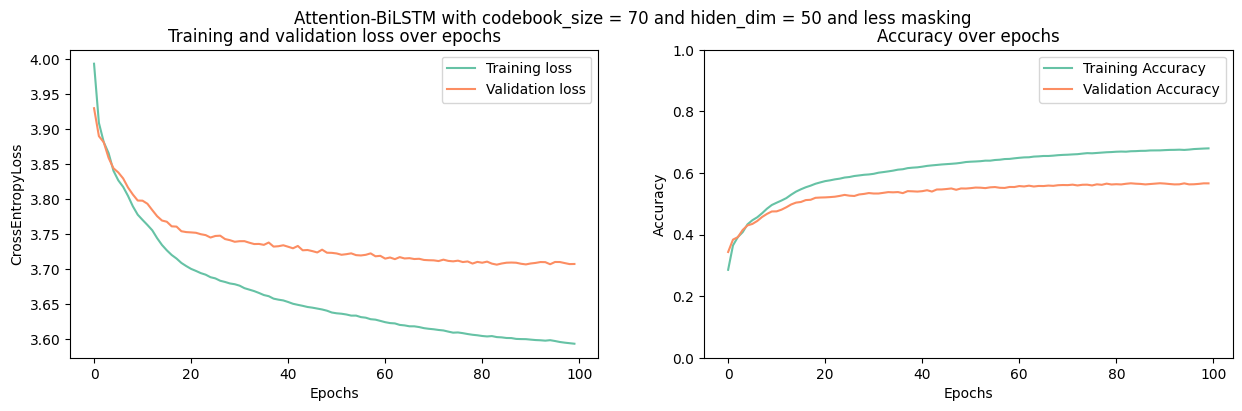

In [130]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('Attention-BiLSTM with codebook_size = 70 and hiden_dim = 50 and less masking')

In [278]:
## Saving the model
with open('models/BestRqEncoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [111]:
pred, label  = model(xtrain[1].view(1,1,-1))
th.argmax(pred)

tensor(24, device='mps:0')

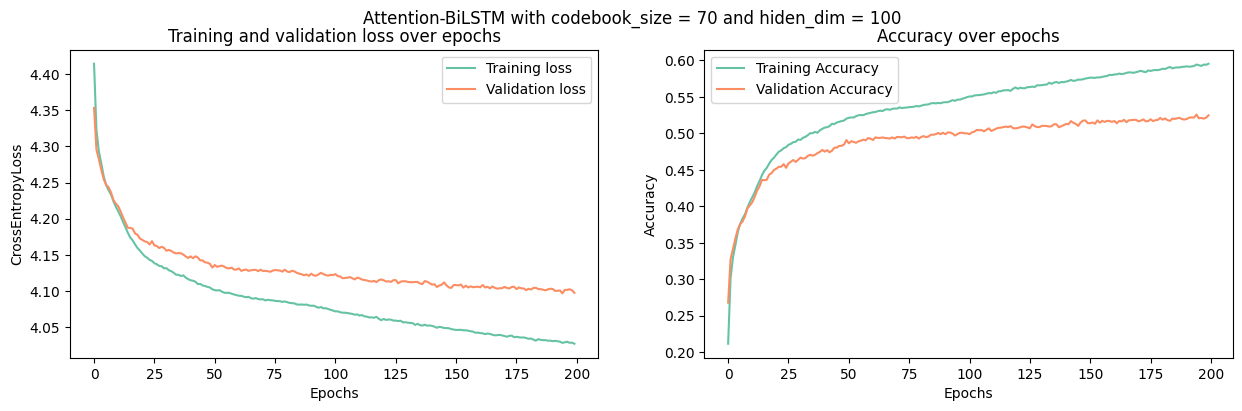

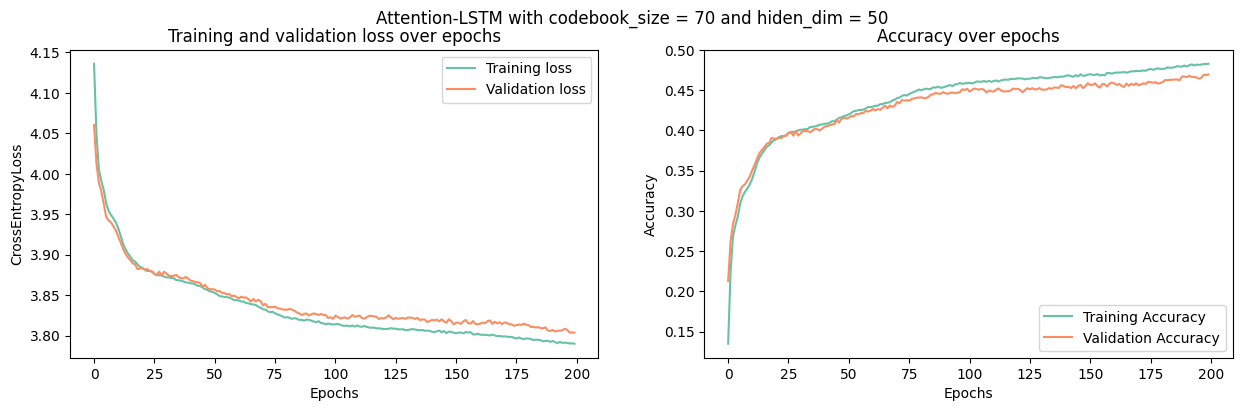

There is some overfitting where the training data is learned in a more efficient way than validation data. (Masking probability here was very high so the LSTM had trouble learning the noise)


In [5]:
class GRUDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, device = 'cpu'):
        super(GRUDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define a list of GRU layers
        self.gru_layers = nn.ModuleList([nn.GRU(input_size if i == 0 else hidden_size,
                                                hidden_size,
                                                batch_first=True)
                                          for i in range(num_layers)])

        # Output layer
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        # Initialize hidden state for each layer
        hidden = [th.zeros(1, input.size(0), self.hidden_size, device= device) for _ in range(self.num_layers)]

        # Forward pass through each layer
        for i, gru_layer in enumerate(self.gru_layers):
            output, hidden[i] = gru_layer(input if i == 0 else output, hidden[i])

        # Output layer
        output = self.softmax(self.out(output[:, :, :]))  # Take only the last output


        return output

In [284]:
test, _ = model(xtrain[:10].view(1, -1, 600))
decoder = GRUDecoder(input_size = 70, hidden_size = 30, output_size = 6, device = device).to(device= device)

In [288]:
encoder(xtrain[:10].view(1, -1, 600).to(device)).shape

torch.Size([10, 70])

In [285]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train_decoder(trainloader= train_loader, validloader= valid_loader, encoder= encoder, decoder= decoder, device= device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [02:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('Encoder + Decoder')

## Trying with spectrogram

In [5]:
class AttentionLSTM_spec(nn.Module):
    def __init__(self, input_dim=201, hidden_dim=100, nstack=2, dropout=0, codebook_size=50, embedding_dim=50):
        super(AttentionLSTM_spec, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=nstack, bidirectional=True)

        # Linear layers for attention
        self.attention_linear = nn.Linear(2 * hidden_dim, 1)
        self.context_linear = nn.Linear(2 * hidden_dim, hidden_dim)

        # Final linear layer
        self.linear = nn.Linear(hidden_dim, codebook_size)

        # Dropout layer
        self.drop = nn.Dropout(p=dropout)

    def init_hidden(self, bsz):
        # Initialize hidden state for LSTM
        return (th.zeros(2 * self.nstack, bsz, self.hidden_dim),
                th.zeros(2 * self.nstack, bsz, self.hidden_dim))

    def forward(self, inputs, h0=None):
        inputs = inputs.permute(0,2,1)
        if h0 is None:
            (h0, c0) = self.init_hidden(inputs.size(1))  # Use size(1) to get the batch size

        h0, c0 = h0.to(inputs.device), c0.to(inputs.device)


        # LSTM forward pass
        lstm_output, _ = self.lstm(inputs, (h0, c0))

        # Compute attention weights
        attention_weights = F.softmax(self.attention_linear(lstm_output), dim=0)


        # Apply attention to LSTM output
        attention_applied = th.sum(attention_weights * lstm_output, dim=1)


        # Compute context vector
        context = self.context_linear(attention_applied)


        context = F.relu(context)

        # Apply dropout
        out = self.drop(context)

        # Linear layer
        out = self.linear(out)

        # Softmax layer
        out = F.softmax(out, dim=1)

        return out

In [7]:
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain, xvalid = compute_spectrogram(xtrain, n_fft = 400, window=th.ones(400)),compute_spectrogram(xvalid, n_fft = 400)
dataset_t = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(dataset_t, batch_size= 500, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
valid_loader = DataLoader(dataset_v, batch_size= 500, shuffle=True)

In [6]:
encoder_spec = AttentionLSTM_spec(input_dim = 201, dropout= 0.2, hidden_dim = 100, codebook_size= 70, nstack = 2).to(device)
def train(trainloader, validloader, model, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels  = inputs.to(device), labels.to(device)
            encoder_outs = model(inputs)
            loss = loss_function(encoder_outs, labels.view(-1).long())
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(encoder_outs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs, labels  = inputs.to(device), labels.to(device)
                encoder_outs = model(inputs)
                loss = loss_function(encoder_outs, labels.view(-1).long())
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(encoder_outs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [368]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train(trainloader = train_loader, validloader = valid_loader, model = encoder_spec, device = device)

 10%|█         | 1/10 [01:06<09:56, 66.24s/it]

Epoch 1/10, Train Loss: 3.9660900472240015, Validation Loss: 3.7805491043971133, Training Accuracy: 0.35860677860166484, Validation Accuracy: 0.5981318004516526


 20%|██        | 2/10 [02:10<08:38, 64.80s/it]

Epoch 2/10, Train Loss: 3.688042462549426, Validation Loss: 3.6639892565898404, Training Accuracy: 0.6092957186283702, Validation Accuracy: 0.6134264011496613


 30%|███       | 3/10 [03:10<07:20, 62.91s/it]

Epoch 3/10, Train Loss: 3.661644221706824, Validation Loss: 3.6601415903140335, Training Accuracy: 0.6151027017813006, Validation Accuracy: 0.6156846643399713


 40%|████      | 4/10 [04:18<06:29, 64.87s/it]

Epoch 4/10, Train Loss: 3.6570498245683583, Validation Loss: 3.6585367704049134, Training Accuracy: 0.6183016562970539, Validation Accuracy: 0.6161979059741326


 50%|█████     | 5/10 [05:18<05:15, 63.08s/it]

Epoch 5/10, Train Loss: 3.6556084034117786, Validation Loss: 3.658438279078557, Training Accuracy: 0.6191084974004943, Validation Accuracy: 0.6162492301375487


 60%|██████    | 6/10 [06:21<04:12, 63.12s/it]

Epoch 6/10, Train Loss: 3.653579566289078, Validation Loss: 3.6553227595793896, Training Accuracy: 0.6208642290974176, Validation Accuracy: 0.6181995483473619


 70%|███████   | 7/10 [07:25<03:10, 63.43s/it]

Epoch 7/10, Train Loss: 3.652657575905323, Validation Loss: 3.6585240058409862, Training Accuracy: 0.6212676496491377, Validation Accuracy: 0.614452884417984


 80%|████████  | 8/10 [08:37<02:12, 66.02s/it]

Epoch 8/10, Train Loss: 3.6529103849421847, Validation Loss: 3.655390604948386, Training Accuracy: 0.6208528651382141, Validation Accuracy: 0.6186101416546911


 90%|█████████ | 9/10 [09:45<01:06, 66.83s/it]

Epoch 9/10, Train Loss: 3.6524541560899126, Validation Loss: 3.6567677228878708, Training Accuracy: 0.6211369641182988, Validation Accuracy: 0.6161979059741326


100%|██████████| 10/10 [11:04<00:00, 66.49s/it]

Epoch 10/10, Train Loss: 3.651277643713084, Validation Loss: 3.655489450845963, Training Accuracy: 0.622023352936163, Validation Accuracy: 0.6177376308766167


In [9]:
device ='cpu'
tmp = RandomProjectionQuantizer(input_dim= 201, quantizer_dim= 100, codebook_size= 200,random_state= 2673834267383, device = device)
xtrain_batched = xtrain.unsqueeze(0).permute(0,1,3,2).to(device)
results  = tmp(xtrain_batched, raw_signal =False)
results

RuntimeError: The expanded size of the tensor (100) must match the existing size (200) at non-singleton dimension 3.  Target sizes: [1, 175995, 7, 100].  Tensor sizes: [1, 1, 100, 200]

In [15]:
xtrain.shape

torch.Size([175995, 201, 7])

In [374]:
xtrain_batched.device

device(type='mps', index=0)